In [1]:
%cd ~

/root


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danilkirichko","key":"0842419f01aaf2e015bd2ac32131eb6f"}'}

In [3]:
mkdir ~/.kaggle

In [4]:
cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c 'sf-dl-car-classification'

100% 1.10G/1.11G [00:25<00:00, 48.6MB/s]
100% 1.11G/1.11G [00:25<00:00, 45.8MB/s]
 95% 466M/489M [00:11<00:00, 33.2MB/s]
100% 489M/489M [00:11<00:00, 44.0MB/s]
  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 205MB/s]
  0% 0.00/78.7k [00:00<?, ?B/s]
100% 78.7k/78.7k [00:00<00:00, 82.9MB/s]


In [7]:
! mkdir train
! unzip train.zip -d train

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/train/6/289339.jpg  
  inflating: train/train/6/289352.jpg  
  inflating: train/train/6/289427.jpg  
  inflating: train/train/6/289694.jpg  
  inflating: train/train/6/28985.jpg  
  inflating: train/train/6/289982.jpg  
  inflating: train/train/6/290058.jpg  
  inflating: train/train/6/290095.jpg  
  inflating: train/train/6/290443.jpg  
  inflating: train/train/6/290521.jpg  
  inflating: train/train/6/290525.jpg  
  inflating: train/train/6/290532.jpg  
  inflating: train/train/6/290627.jpg  
  inflating: train/train/6/291015.jpg  
  inflating: train/train/6/291267.jpg  
  inflating: train/train/6/291506.jpg  
  inflating: train/train/6/291533.jpg  
  inflating: train/train/6/29174.jpg  
  inflating: train/train/6/291853.jpg  
  inflating: train/train/6/291864.jpg  
  inflating: train/train/6/2919.jpg  
  inflating: train/train/6/292006.jpg  
  inflating: train/train/6/292106.jpg  
  inflating: tra

In [8]:
! mkdir test
! unzip test.zip -d test

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/test_upload/71564.jpg  
  inflating: test/test_upload/81467.jpg  
  inflating: test/test_upload/72882.jpg  
  inflating: test/test_upload/93954.jpg  
  inflating: test/test_upload/305712.jpg  
  inflating: test/test_upload/67576.jpg  
  inflating: test/test_upload/4429.jpg  
  inflating: test/test_upload/65752.jpg  
  inflating: test/test_upload/41932.jpg  
  inflating: test/test_upload/63838.jpg  
  inflating: test/test_upload/84283.jpg  
  inflating: test/test_upload/96140.jpg  
  inflating: test/test_upload/69073.jpg  
  inflating: test/test_upload/296321.jpg  
  inflating: test/test_upload/29488.jpg  
  inflating: test/test_upload/308138.jpg  
  inflating: test/test_upload/82796.jpg  
  inflating: test/test_upload/305572.jpg  
  inflating: test/test_upload/82642.jpg  
  inflating: test/test_upload/88054.jpg  
  inflating: test/test_upload/3808.jpg  
  inflating: test/test_upload/67753.jpg  
  infl

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from tqdm import tqdm
from google.colab import files

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


In [34]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
RANDOM_SEED = 1
EPOCHS               = 15  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 299 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [11]:
train_df = pd.read_csv("train.csv")
sample_submission = pd.read_csv("sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

/root/train/train/0


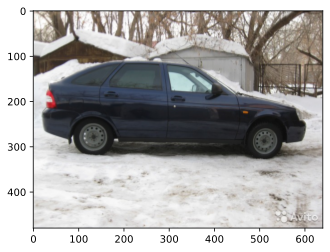

/root


In [ ]:
%cd train/train/0
image = PIL.Image.open('100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size
%cd ~

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=2,
    height_shift_range=2,
    brightness_range=[0.1,1],
    horizontal_flip=False,  
    vertical_flip=True,
    validation_split=VAL_SPLIT # set validation split
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

In [43]:
train_generator = train_datagen.flow_from_directory(
    'train/train',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED) # set as training data

test_generator = test_datagen.flow_from_directory(
    'train/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory='test/test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 15561 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [63]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [36]:
base_model.trainable = False

In [64]:
model=M.Sequential()
model.add(base_model)

model.add(L.GlobalAveragePooling2D())
model.add(L.BatchNormalization())

model.add(L.Dense(256, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(64, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.3))

model.add(L.Dense(16, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.4))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.0001), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 21,389,618
Trainable params: 527,626
Non-trainable params: 20,861,992
____________________________________

In [65]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks_list = [checkpoint,LR]

In [66]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 5,
        callbacks = callbacks_list
)

Epoch 1/20
487/487 [==============================] - ETA: 0s - loss: 1.2682 - accuracy: 0.6061
Epoch 00001: saving model to best_model.hdf5
487/487 [==============================] - 507s 1s/step - loss: 1.2682 - accuracy: 0.6061 - val_loss: 0.4112 - val_accuracy: 0.9369
Epoch 2/20
487/487 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.8627
Epoch 00002: saving model to best_model.hdf5
487/487 [==============================] - 507s 1s/step - loss: 0.6288 - accuracy: 0.8627 - val_loss: 0.2185 - val_accuracy: 0.9657
Epoch 3/20
487/487 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.9170
Epoch 00003: saving model to best_model.hdf5
487/487 [==============================] - 506s 1s/step - loss: 0.4640 - accuracy: 0.9170 - val_loss: 0.1608 - val_accuracy: 0.9747
Epoch 4/20
487/487 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.9356
Epoch 00004: saving model to best_model.hdf5
487/487 [==============================]

KeyboardInterrupt: ignored

In [44]:
scores = model.evaluate(test_generator, verbose=1, steps=len(test_generator), batch_size=100)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 49s 670ms/step - loss: 0.9941 - accuracy: 0.6934
Accuracy: 69.34%


In [45]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
LR = 0.00005
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 42,147,481
Trainable params: 39,717,228
Non-trainable params: 2,430,253
____________________________________

In [46]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 5,
        callbacks = callbacks_list
)

Epoch 1/5
487/487 [==============================] - ETA: 0s - loss: 1.1261 - accuracy: 0.6284
Epoch 00001: saving model to best_model.hdf5
487/487 [==============================] - 395s 812ms/step - loss: 1.1261 - accuracy: 0.6284 - val_loss: 0.5477 - val_accuracy: 0.8682
Epoch 2/5
487/487 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.7700
Epoch 00002: saving model to best_model.hdf5
487/487 [==============================] - 395s 811ms/step - loss: 0.8064 - accuracy: 0.7700 - val_loss: 0.3904 - val_accuracy: 0.9249
Epoch 3/5
487/487 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.8314
Epoch 00003: saving model to best_model.hdf5
487/487 [==============================] - 396s 812ms/step - loss: 0.6648 - accuracy: 0.8314 - val_loss: 0.3127 - val_accuracy: 0.9442
Epoch 4/5
487/487 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.8678
Epoch 00004: saving model to best_model.hdf5
487/487 [==========================

In [47]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 49s 673ms/step - loss: 0.2094 - accuracy: 0.9644
Accuracy: 96.44%


In [48]:
base_model.trainable = True

fine_tune_at = 50

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
LR = 0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [49]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 5,
        callbacks = callbacks_list
)

Epoch 1/5
487/487 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8850
Epoch 00001: saving model to best_model.hdf5
487/487 [==============================] - 419s 861ms/step - loss: 0.4838 - accuracy: 0.8850 - val_loss: 0.1832 - val_accuracy: 0.9717
Epoch 2/5
487/487 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.9073
Epoch 00002: saving model to best_model.hdf5
487/487 [==============================] - 424s 870ms/step - loss: 0.4439 - accuracy: 0.9073 - val_loss: 0.1649 - val_accuracy: 0.9717
Epoch 3/5
487/487 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.9192
Epoch 00003: saving model to best_model.hdf5
487/487 [==============================] - 428s 880ms/step - loss: 0.4188 - accuracy: 0.9192 - val_loss: 0.1490 - val_accuracy: 0.9798
Epoch 4/5
487/487 [==============================] - ETA: 0s - loss: 0.3918 - accuracy: 0.9274
Epoch 00004: saving model to best_model.hdf5
487/487 [==========================

In [50]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 49s 671ms/step - loss: 0.1266 - accuracy: 0.9850
Accuracy: 98.50%


In [55]:
base_model.trainable = True
LR = 0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [58]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator)//4,
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 8,
        callbacks = callbacks_list
)

Epoch 1/8
121/121 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.9323
Epoch 00001: saving model to best_model.hdf5
121/121 [==============================] - 164s 1s/step - loss: 0.3733 - accuracy: 0.9323 - val_loss: 0.1297 - val_accuracy: 0.9850
Epoch 2/8
121/121 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.9323
Epoch 00002: saving model to best_model.hdf5
121/121 [==============================] - 164s 1s/step - loss: 0.3640 - accuracy: 0.9323 - val_loss: 0.1284 - val_accuracy: 0.9833
Epoch 3/8
121/121 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9379
Epoch 00003: saving model to best_model.hdf5
121/121 [==============================] - 163s 1s/step - loss: 0.3591 - accuracy: 0.9379 - val_loss: 0.1212 - val_accuracy: 0.9858
Epoch 4/8
121/121 [==============================] - ETA: 0s - loss: 0.3729 - accuracy: 0.9316
Epoch 00004: saving model to best_model.hdf5
121/121 [==============================] - 1

KeyboardInterrupt: ignored

In [59]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

30/73 [===========>..................] - ETA: 28s - loss: 0.1192 - accuracy: 0.9844

KeyboardInterrupt: ignored

In [ ]:
test_sub_generator.samples

6675

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: ignored

In [67]:

test_sub_generator.reset()

tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

  0%|          | 0/10 [00:00<?, ?it/s]

209/209 [==============================] - 142s 680ms/step


 10%|█         | 1/10 [02:23<21:35, 143.95s/it]

209/209 [==============================] - 142s 678ms/step


 20%|██        | 2/10 [04:47<19:09, 143.68s/it]

209/209 [==============================] - 141s 674ms/step


 30%|███       | 3/10 [07:09<16:42, 143.21s/it]

209/209 [==============================] - 141s 674ms/step


 40%|████      | 4/10 [09:31<14:17, 142.88s/it]

209/209 [==============================] - 140s 672ms/step


 50%|█████     | 5/10 [11:52<11:52, 142.54s/it]

209/209 [==============================] - 141s 674ms/step


 60%|██████    | 6/10 [14:15<09:29, 142.43s/it]

209/209 [==============================] - 141s 673ms/step


 70%|███████   | 7/10 [16:37<07:06, 142.28s/it]

209/209 [==============================] - 141s 676ms/step


 80%|████████  | 8/10 [18:59<04:44, 142.39s/it]

209/209 [==============================] - 141s 675ms/step


 90%|█████████ | 9/10 [21:22<02:22, 142.39s/it]

209/209 [==============================] - 142s 678ms/step


100%|██████████| 10/10 [23:45<00:00, 142.51s/it]


In [68]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [69]:

files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>